<a href="https://colab.research.google.com/github/YusufCanDemirkol/youtube-video-cover-classification/blob/main/Beit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision transformers


In [ ]:
import torch
from transformers import BeitForImageClassification, BeitFeatureExtractor
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.optim import AdamW
import time


In [ ]:
import os
import zipfile
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Verileri çıkarmak için temel yol
data_dir = "/content/drive/MyDrive/data"

# ZIP dosyalarını çıkar
zip_files = [
    ("belgeseltrain.zip", "train"),
    ("derstrain.zip", "train"),
    ("oyuntrain.zip", "train"),
    ("sportrain.zip", "train"),
    ("yemektrain.zip", "train"),
    ("belgeseltest.zip", "test"),
    ("derstest.zip", "test"),
    ("oyuntest.zip", "test"),
    ("spor test.zip", "test"),
    ("yemektest.zip", "test")
]

for zip_file, folder in zip_files:
    zip_path = os.path.join(data_dir, folder, zip_file)
    extract_path = os.path.join("/content", folder)  # İçerik 'content/train' ve 'content/test' altında olacak
    os.makedirs(extract_path, exist_ok=True)  # Klasör yoksa oluştur
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Veri dönüşümleri
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize et
])

# Eğitim ve doğrulama veri setlerini yükle
train_dataset = datasets.ImageFolder("/content/train", transform=transform)
val_dataset = datasets.ImageFolder("/content/test", transform=transform)

# DataLoader oluşturma
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Sınıf isimlerini kontrol et
print("Sınıf isimleri:", train_dataset.classes)



Sınıf isimleri: ['belgeseltrain', 'derstrain', 'oyuntrain', 'sportrain', 'yemektrain']


In [ ]:
from transformers import BeitForImageClassification, AutoImageProcessor

# BEiT modeli ve özellik çıkarıcıyı yükleyin
model_name = "microsoft/beit-base-patch16-224"
feature_extractor = AutoImageProcessor.from_pretrained(model_name)
model = BeitForImageClassification.from_pretrained(model_name)

# Sınıf sayısını veri setinize göre yeniden ayarlayın
model.classifier = torch.nn.Linear(model.config.hidden_size, len(train_dataset.classes))

# Modeli cihaza taşıyın
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (int

Epoch 1/10, Training Loss: 0.2829, Validation Loss: 0.1868, Time: 876.07s
Epoch 2/10, Training Loss: 0.0922, Validation Loss: 0.1375, Time: 877.88s
Epoch 3/10, Training Loss: 0.0350, Validation Loss: 0.1951, Time: 878.08s
Epoch 4/10, Training Loss: 0.0322, Validation Loss: 0.1619, Time: 876.98s
Epoch 5/10, Training Loss: 0.0254, Validation Loss: 0.1725, Time: 877.24s
Epoch 6/10, Training Loss: 0.0300, Validation Loss: 0.1765, Time: 876.45s
Epoch 7/10, Training Loss: 0.0216, Validation Loss: 0.1806, Time: 875.79s
Epoch 8/10, Training Loss: 0.0214, Validation Loss: 0.1885, Time: 875.92s
Validation loss 6 epoch boyunca iyileşmedi. Eğitim erken sonlandırılıyor.
Total Training Time: 7014.41 seconds


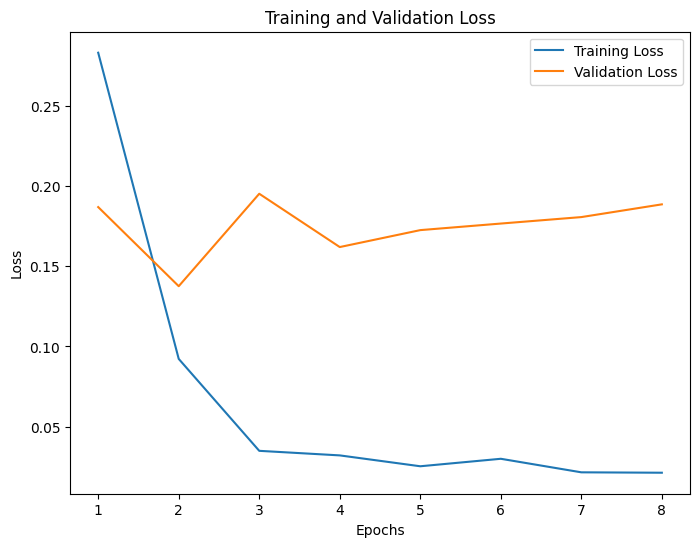

In [ ]:
import time
import matplotlib.pyplot as plt
from torch.optim import AdamW
import torch

# Optimizer ve kayıp fonksiyonu
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

# Eğitim ve doğrulama parametreleri
epochs = 10
train_losses, val_losses = [], []

# Erken durdurma için değişkenler
patience = 6  # Maksimum tolerans epoch sayısı
no_improve_counter = 0  # İyileşme yoksa artar
best_val_loss = float('inf')

total_start_time = time.time()  # Toplam eğitim süresi başlangıcı

for epoch in range(epochs):
    epoch_start_time = time.time()

    # Eğitim modu
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Doğrulama modu
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_duration:.2f}s")

    # Erken durdurma kontrolü
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_counter = 0
    else:
        no_improve_counter += 1
        if no_improve_counter >= patience:
            print(f"Validation loss 6 epoch boyunca iyileşmedi. Eğitim erken sonlandırılıyor.")
            break

total_training_time = time.time() - total_start_time  # Toplam eğitim süresi
print(f"Total Training Time: {total_training_time:.2f} seconds")

# Eğitim ve doğrulama kayıplarını görselleştirme
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


In [ ]:
### Modeli Kaydetmek için Kod ###
import torch

def save_model(model, path):
    """
    Eğitilmiş modeli belirtilen yola kaydeder.

    Args:
        model: PyTorch modeli
        path: Kaydedilecek dosya yolu (str)
    """
    torch.save(model.state_dict(), path)
    print(f"Model başarıyla kaydedildi: {path}")

# Modeli kaydetme örneği
model_save_path = "/content/drive/MyDrive/beit_model.pth"
save_model(model, model_save_path)




Model başarıyla kaydedildi: /content/drive/MyDrive/beit_model.pth


Average Inference Time per Batch: 0.2366 seconds


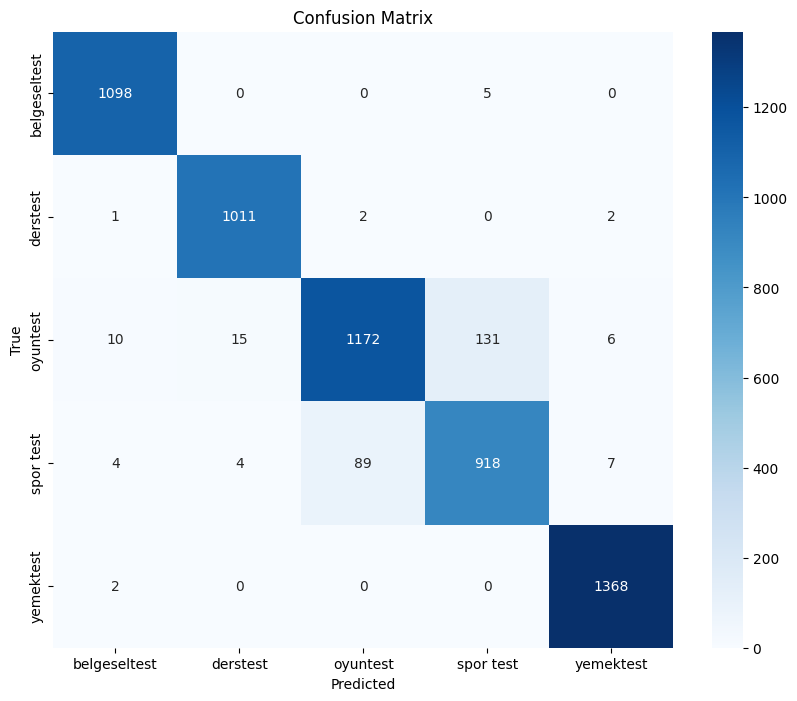

Accuracy: 0.9524
Precision: 0.9509
Recall: 0.9532
F1-Score: 0.9518
Sensitivity: 0.9532
Specificity: 0.9882


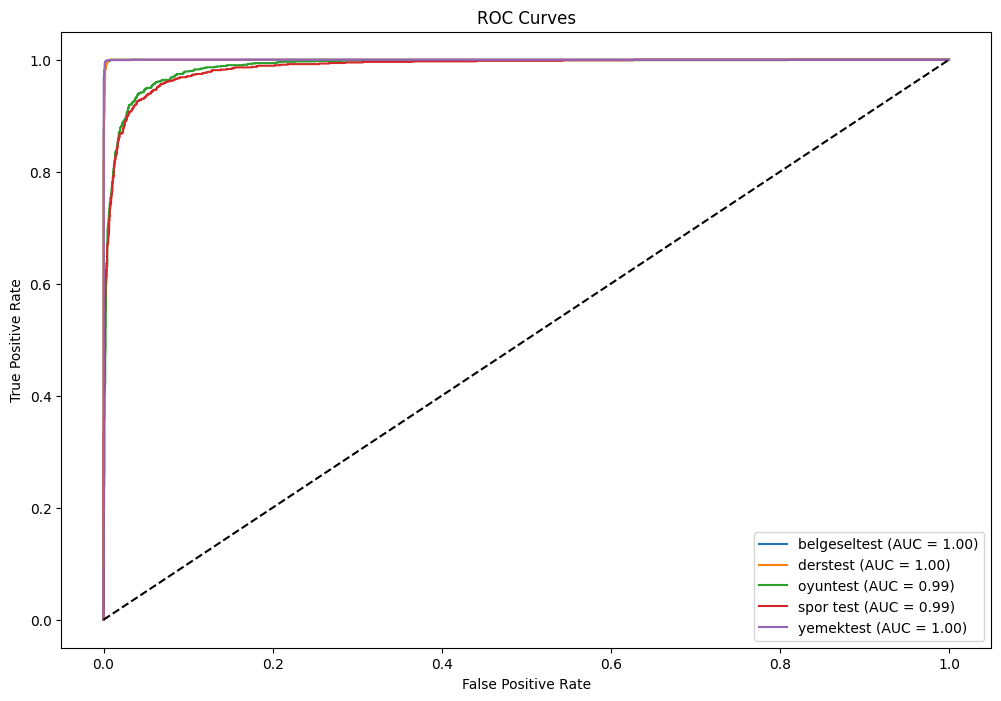

In [ ]:
import time
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Doğrulama veri setinde test yapın
all_labels = []
all_preds = []
all_probs = []  # Sınıf olasılıklarını tutmak için

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        start_time = time.time()
        outputs = model(images).logits
        inference_time = time.time() - start_time  # Çıkarım zamanı hesaplama
        _, preds = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Çıkarım zamanı ortalaması
print(f"Average Inference Time per Batch: {inference_time:.4f} seconds")

# Karmaşıklık Matrisi
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Accuracy, Recall, Precision, F1-Score
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="macro")
recall = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Sensitivity ve Specificity hesaplama
sensitivity = recall  # Sensitivity genelde recall ile aynıdır
specificity = []
cm = cm.astype(np.float32)
for i in range(len(cm)):
    tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    fp = np.sum(cm[:, i]) - cm[i, i]
    specificity.append(tn / (tn + fp))
specificity = np.mean(specificity)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# ROC ve AUC
num_classes = len(val_dataset.classes)
y_true = np.eye(num_classes)[np.array(all_labels)]
all_probs = np.array(all_probs)

plt.figure(figsize=(12, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{val_dataset.classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], "k--")  # Rastgele tahmin çizgisi
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()


In [ ]:
import torch
from transformers import BeitForImageClassification, AutoImageProcessor

def load_model(path, num_classes):
    """
    Eğitilmiş BEiT modelini belirtilen dosya yolundan yükler ve sınıf sayısını ayarlar.

    Args:
        path: Kaydedilen model dosyasının yolu (str)
        num_classes: Veri setindeki sınıf sayısı (int)

    Returns:
        Yüklenen model (PyTorch modeli)
    """
    # Model adı ve özellik çıkarıcı
    model_name = "microsoft/beit-base-patch16-224"
    feature_extractor = AutoImageProcessor.from_pretrained(model_name)

    # BEiT modelini oluştur ve sınıf sayısını ayarla
    model = BeitForImageClassification.from_pretrained(
        model_name,
        ignore_mismatched_sizes=True  # Sınıf sayısı uyumsuzluğu durumunda kullanılabilir
    )
    model.classifier = torch.nn.Linear(model.config.hidden_size, num_classes)

    # Model ağırlıklarını yükle
    model.load_state_dict(torch.load(path))

    # Modeli cihaza taşı
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f"Model başarıyla yüklendi: {path}")
    return model

# Modeli yükleme örneği
model_save_path = "/content/drive/MyDrive/beit_model.pth"
num_classes = 5  # Veri setinizdeki sınıf sayısı
model = load_model(model_save_path, num_classes)


<ipython-input-7-035e36466b6b>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Model başarıyla yüklendi: /content/drive/MyDrive/beit_model.pth


In [ ]:
import time

# BEiT modeli ile çıkarım zamanı (inference time) hesaplama
model.eval()  # Modeli değerlendirme moduna alın

inference_start_time = time.time()  # Çıkarım işleminin başlangıç zamanı

with torch.no_grad():  # Gradients hesaplanmadan çıkarım
    for images, labels in val_loader:
        images = images.to(device)  # Görselleri cihaza yükle (GPU veya CPU)
        outputs = model(images).logits  # Model tahmini

inference_end_time = time.time()  # Çıkarım işleminin bitiş zamanı

# Toplam çıkarım süresi
inference_time = inference_end_time - inference_start_time
print(f"Inference Time: {inference_time:.2f} seconds")


Inference Time: 68.49 seconds
